# Bioconductor on AnVIL GPU

Bioconductor can now be used on the terra 

In [1]:
BiocManager::version()

[1] '3.15'

In [2]:
BiocManager::install('VAExprs')

library(VAExprs)

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.15 (BiocManager 1.30.16), R Under development (unstable)
  (2021-12-19 r81394)

Warning message:
"package(s) not installed when version(s) same as current; use `force = TRUE` to
  re-install: 'VAExprs'"
Old packages: 'BiocParallel', 'glue', 'mgcv', 'XML'

Loading required package: keras

Loading required package: mclust

Package 'mclust' version 5.4.9
Type 'citation("mclust")' for citing this R package in publications.



In [4]:
reticulate::use_virtualenv(virtualenv = '/Users/nitesh/virtualenvs/ds-env')

In [5]:
reticulate::py_config()

python:         /Users/nitesh/virtualenvs/ds-env/bin/python
libpython:      /usr/local/opt/python@3.9/Frameworks/Python.framework/Versions/3.9/lib/python3.9/config-3.9-darwin/libpython3.9.dylib
pythonhome:     /Users/nitesh/virtualenvs/ds-env:/Users/nitesh/virtualenvs/ds-env
version:        3.9.9 (main, Nov 21 2021, 03:23:44)  [Clang 13.0.0 (clang-1300.0.29.3)]
numpy:          /Users/nitesh/virtualenvs/ds-env/lib/python3.9/site-packages/numpy
numpy_version:  1.21.4
tensorflow:     /Users/nitesh/virtualenvs/ds-env/lib/python3.9/site-packages/tensorflow

NOTE: Python version was forced by use_python function

## Start vignette of VAExprs

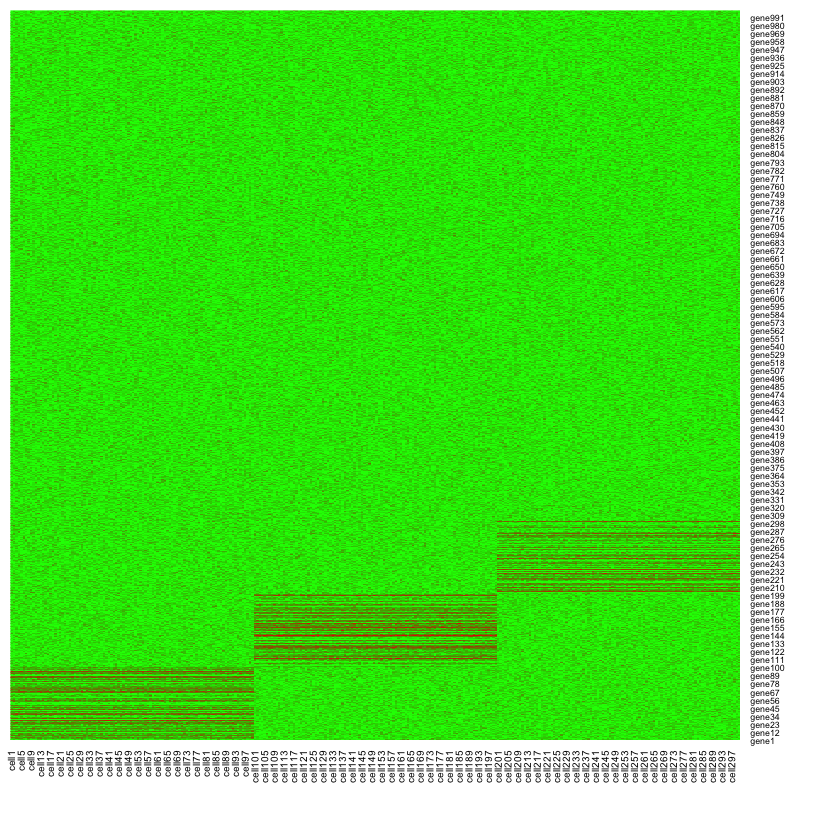

In [6]:
## ---- eval=TRUE---------------------------------------------------------------
if (keras::is_keras_available() & reticulate::py_available()) {
    library(VAExprs)
    
    ### simulate differentially expressed genes
    set.seed(1)
    g <- 3
    n <- 100
    m <- 1000
    mu <- 5
    sigma <- 5
    mat <- matrix(rnorm(n*m*g, mu, sigma), m, n*g)
    rownames(mat) <- paste0("gene", seq_len(m))
    colnames(mat) <- paste0("cell", seq_len(n*g))
    group <- factor(sapply(seq_len(g), function(x) { 
        rep(paste0("group", x), n)
    }))
    names(group) <- colnames(mat)
    mu_upreg <- 6
    sigma_upreg <- 10
    deg <- 100
    for (i in seq_len(g)) {
        mat[(deg*(i-1) + 1):(deg*i), group == paste0("group", i)] <- 
            mat[1:deg, group==paste0("group", i)] + rnorm(deg, mu_upreg, sigma_upreg)
    }
    # positive expression only
    mat[mat < 0] <- 0
    x_train <- as.matrix(t(mat))
    
    # heatmap
    heatmap(mat, Rowv = NA, Colv = NA, 
            col = colorRampPalette(c('green', 'red'))(100), 
            scale = "none")
}

In [7]:
## ---- eval=TRUE---------------------------------------------------------------
if (keras::is_keras_available() & reticulate::py_available()) {
    # model parameters
    batch_size <- 32
    original_dim <- 1000
    intermediate_dim <- 512
    epochs <- 100
    
    # VAE
    vae_result <- fit_vae(x_train = x_train, x_val = x_train,
                        encoder_layers = list(layer_input(shape = c(original_dim)),
                                            layer_dense(units = intermediate_dim,
                                                        activation = "relu")),
                        decoder_layers = list(layer_dense(units = intermediate_dim,
                                                        activation = "relu"),
                                            layer_dense(units = original_dim,
                                                        activation = "sigmoid")),
                        epochs = epochs, batch_size = batch_size,
                        use_generator = FALSE,
                        callbacks = keras::callback_early_stopping(
                            monitor = "val_loss",
                            patience = 10,
                            restore_best_weights = TRUE))
}

Loaded Tensorflow version 2.8.0

normalizing...

training...



In [8]:
## ---- eval=TRUE---------------------------------------------------------------
if (keras::is_keras_available() & reticulate::py_available()) {
    # model architecture
    plot_vae(vae_result$model)
}

HTML widgets cannot be represented in plain text (need html)

generating...

post-processing...



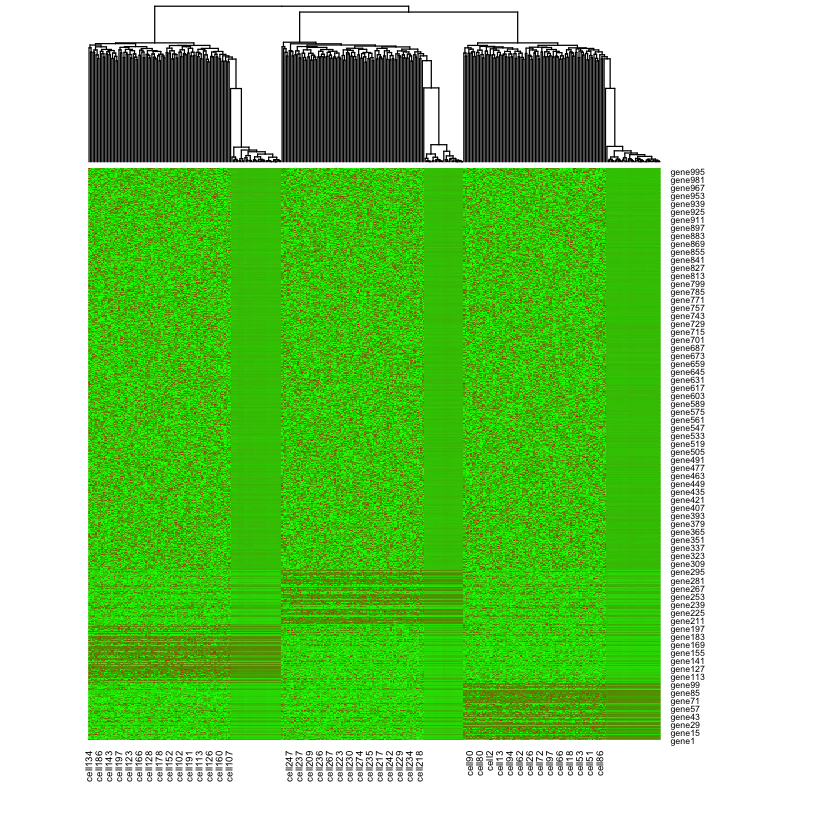

In [9]:

## ---- eval=TRUE---------------------------------------------------------------
if (keras::is_keras_available() & reticulate::py_available()) {
    # sample generation
    set.seed(1)
    gen_sample_result <- gen_exprs(vae_result, num_samples = 100)
    
    # heatmap
    heatmap(cbind(t(x_train), t(gen_sample_result$x_gen)),
            col = colorRampPalette(c('green', 'red'))(100),
            Rowv=NA)
}


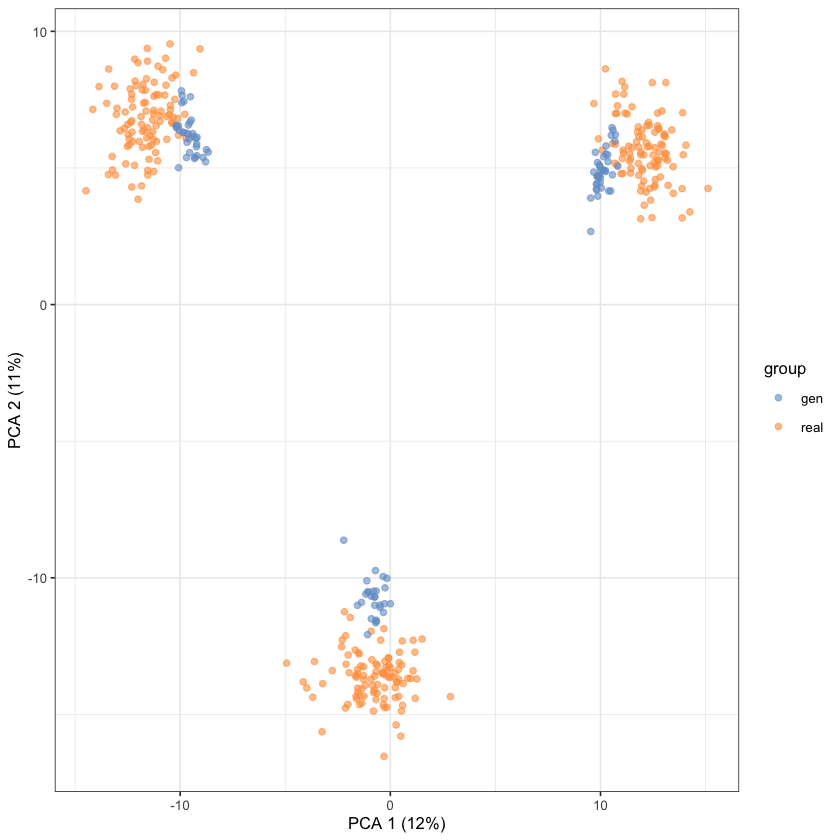

In [10]:
## ---- eval=TRUE---------------------------------------------------------------
if (keras::is_keras_available() & reticulate::py_available()) {
    # plot for augmented data
    plot_aug(gen_sample_result, "PCA")
}


In [12]:
BiocManager::install('SC3')

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.15 (BiocManager 1.30.16), R Under development (unstable)
  (2021-12-19 r81394)

Installing package(s) 'SC3'

also installing the dependencies 'gtools', 'proxy', 'gplots', 'e1071', 'pheatmap', 'ROCR', 'WriteXLS'


Warning message in .inet_warning(msg):
"unable to access index for repository https://cran.r-project.org/bin/macosx/contrib/4.2:
  cannot open URL 'https://cran.r-project.org/bin/macosx/contrib/4.2/PACKAGES'"
Packages which are only available in source form, and may need
  compilation of C/C++/Fortran: 'gtools' 'proxy' 'e1071'




The downloaded binary packages are in
	/var/folders/1w/xf7rrsr1483d4rg7vwbkdy780000gp/T//Rtmpztw6b5/downloaded_packages


installing the source packages 'gtools', 'proxy', 'gplots', 'e1071', 'pheatmap', 'ROCR', 'WriteXLS'


Old packages: 'BiocParallel', 'glue', 'mgcv', 'XML'



In [13]:

## ---- eval=TRUE---------------------------------------------------------------
if (keras::is_keras_available() & reticulate::py_available()) {
    library(VAExprs)
    library(SC3)
    library(SingleCellExperiment)
    
    # create a SingleCellExperiment object
    sce <- SingleCellExperiment::SingleCellExperiment(
        assays = list(counts = as.matrix(yan)),
        colData = ann
    )
    
    # define feature names in feature_symbol column
    rowData(sce)$feature_symbol <- rownames(sce)
    # remove features with duplicated names
    sce <- sce[!duplicated(rowData(sce)$feature_symbol), ]
    # remove genes that are not expressed in any samples
    sce <- sce[which(rowMeans(assay(sce)) > 0),]
    dim(assay(sce))
    
    # model parameters
    batch_size <- 32
    original_dim <- 19595
    intermediate_dim <- 256
    epochs <- 100
    
    # model
    cvae_result <- fit_vae(object = sce,
                        encoder_layers = list(layer_input(shape = c(original_dim)),
                                            layer_dense(units = intermediate_dim,
                                                        activation = "relu")),
                        decoder_layers = list(layer_dense(units = intermediate_dim,
                                                        activation = "relu"),
                                            layer_dense(units = original_dim,
                                                        activation = "sigmoid")),
                        epochs = epochs, batch_size = batch_size,
                        use_generator = TRUE,
                        callbacks = keras::callback_early_stopping(
                            monitor = "loss",
                            patience = 20,
                            restore_best_weights = TRUE))
    
    # model architecture
    plot_vae(cvae_result$model)
}


Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: 'MatrixGenerics'


The following objects are masked from 'package:matrixStats':

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges

HTML widgets cannot be represented in plain text (need html)

generating...

post-processing...



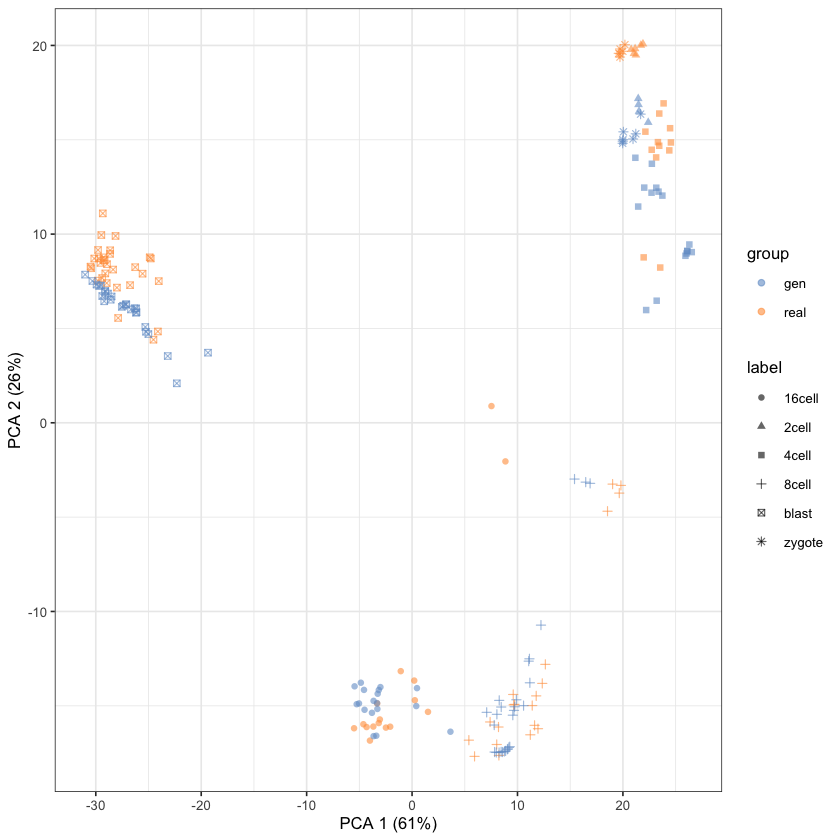

In [14]:

## ---- eval=TRUE---------------------------------------------------------------
if (keras::is_keras_available() & reticulate::py_available()) {
    # sample generation
    set.seed(1)
    gen_sample_result <- gen_exprs(cvae_result, 100,
                                batch_size, use_generator = TRUE)
    
    # plot for augmented data
    plot_aug(gen_sample_result, "PCA")
}

In [15]:
sessionInfo()

R Under development (unstable) (2021-12-19 r81394)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Big Sur/Monterey 10.16

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.2/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.2/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] SingleCellExperiment_1.17.2 SummarizedExperiment_1.25.3
 [3] Biobase_2.55.0              GenomicRanges_1.47.6       
 [5] GenomeInfoDb_1.31.4         IRanges_2.29.1             
 [7] S4Vectors_0.33.10           BiocGenerics_0.41.2        
 [9] MatrixGenerics_1.7.0        matrixStats_0.61.0         
[11] SC3_1.23.0                  VAExprs_1.1.1              
[13] mclust_5.4.9                keras_2.8.0                

loaded via a namespace (an